<a href="https://colab.research.google.com/github/Richardjmorton/colab/blob/master/Using_JAX_for_Hinode_EIS_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook shows the benefit of using JAX to undertaken MLE or least-squares fitting of spectral lines. 

Here data from Hinode EIS is used.

# Initial set-up

In [1]:
# import modules
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
%matplotlib inline

from scipy.optimize import minimize

import astropy.units as u
import astropy.constants as const

from jax import jacobian, jit, device_put, device_get
from jax.scipy.optimize import minimize as jminimize
from jax import vmap
import jax.numpy as jnp

from itertools import product

import os
import urllib.request



Check TPU details for colab, these cells can be ignored if running on CPU/GPU.

In [ ]:
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu()

In [ ]:
import jax
jax.devices()

[GpuDevice(id=0, process_index=0)]

Download a data set from the NRL repository.

In [3]:
urllib.request.urlretrieve('https://eis.nrl.navy.mil/level1/hdf5/2007/01/18/eis_20070118_181213.data.h5', 'eis_20070118_181213.data.h5')
urllib.request.urlretrieve('https://eis.nrl.navy.mil/level1/hdf5/2007/01/18/eis_20070118_181213.head.h5', 'eis_20070118_181213.head.h5')
os.listdir() 

['.config',
 'eis_20070118_181213.data.h5',
 'eis_20070118_181213.head.h5',
 'sample_data']

Need to clone the github repsoitory to install and run the EISPAC software.

In [4]:
! git clone https://github.com/USNavalResearchLaboratory/eispac.git

Cloning into 'eispac'...
remote: Enumerating objects: 1525, done.
remote: Counting objects: 100% (1525/1525), done.
remote: Compressing objects: 100% (1012/1012), done.
remote: Total 1525 (delta 663), reused 1315 (delta 504), pack-reused 0
Receiving objects: 100% (1525/1525), 43.53 MiB | 14.74 MiB/s, done.
Resolving deltas: 100% (663/663), done.


In [5]:
# install EISPAC
!python -m pip install eispac/.

Processing ./eispac
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 6.0 MB 9.8 MB/s 
     |████████████████████████████████| 108 kB 47.9 MB/s 
     |████████████████████████████████| 104 kB 45.8 MB/s 
     |████████████████████████████████| 402 kB 50.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 60 kB 7.6 MB/s 
     |████████████████████████████████| 68 kB 6.1 MB/s 
     |████████████████████████████████| 191 kB 54.0 MB/s 
  Installing build dependencies ... done
  Getting requir

Check the files in the directory.

In [6]:
os.listdir()

['.config',
 'eis_20070118_181213.data.h5',
 'eispac',
 'eis_20070118_181213.head.h5',
 'sample_data']

Read the data using EISPAC

In [7]:
from eispac import read_cube
path = 'eis_20070118_181213.data.h5'
wave_len = 284

eis_cube = read_cube(path, wave_len)

Data file,
   /content/eis_20070118_181213.data.h5
Header file,
   /content/eis_20070118_181213.head.h5
Found a wavelength 284.00 [Angstroms] in window 8
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


Plot the data at the central wavelength.

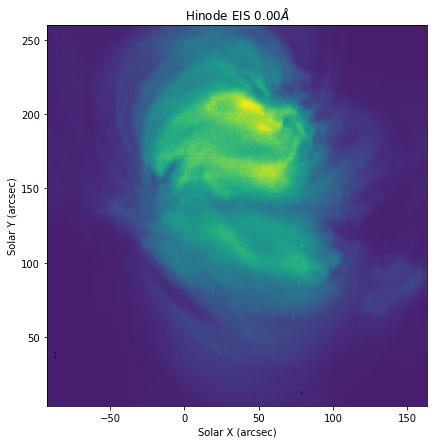

In [8]:
def convert_pix_2_coords(x,y):
    x_coord = (cent_x+(x-crpix_x)*cdelt_x)*deg_2_arcsec
    y_coord = (cent_y+(y-crpix_y)*cdelt_y)*deg_2_arcsec
    
    return x_coord, y_coord
    
ny,nx,nwave = eis_cube.data.shape

cent_wav, cent_x, cent_y = eis_cube.wcs.wcs.crval
cdelt_wav, cdelt_x, cdelt_y = eis_cube.wcs.wcs.cdelt
crpix_wav, crpix_x, crpix_y = eis_cube.wcs.wcs.crpix

deg_2_arcsec = 3600

x_extent, y_extent = convert_pix_2_coords([0,nx],[0,ny])

extent_vec = [x_extent[0],x_extent[1],y_extent[0],y_extent[1]]

plt.figure(figsize=(7,7))
plt.imshow(eis_cube.data[:,:,11], origin='lower', extent=extent_vec)
plt.xlabel('Solar X (arcsec)')
plt.ylabel('Solar Y (arcsec)')
plt.title(r'Hinode EIS {:1.2f}$\AA$'.format(cent_wav));

# Defining the objective function

To use `scipy.optmize.minimise` (or `jax.scipy.minimize`), an objective function (alternatively loss or cost) needs to specified. From a Maximim Likelihood viewpoint, this is the likelihood function. 

For data with a large number of photon counts, then one can assume normally distributed noise and the derive the negative log-likelihood function 

$$
- \ln\mathcal{L} = \sum 0.5 \ln(2\pi\sigma_i^2) - \sum \frac{(y_i - \mu_i)^2}{2\sigma_i^2},
$$
where $y_i$ are the intensity values and $\sigma_i$ is the uncertainties on those values. Finally, $\mu_i=f(\vec{\theta})$ is the model that describes the data with a vector of parameters $\vec{\theta}$.



In [9]:
# Negative log-likelihood

def neg_loglike_jx(theta, x, y, sigma, model):
    """
    Return Gaussian negative log-likelihood for unknown sigma

    Parameters
    ----------
    theta - model parameters, theta[0] should always be the estimate for sigma
    x - 1d array
        x values of data
    y - 1d array
        y values of data
    model - function 
            model to fit to the data
    """
    
    N = len(x)
    mu = model(theta, x)

    # this is the Equation shown above
    #ll = -jnp.sum(0.5 * jnp.log(2*np.pi*sigma**2)) - \
    #    (jnp.sum(jnp.square(y - mu)/2/sigma**2))
    ll = -(jnp.sum(jnp.square(y - mu)/2/sigma**2))

    return -1 * ll   # note - no factor of 2 here

The we define the potential models for the data.

In [10]:
def single_gauss(p, x):
    # single gaussian plus constant
    # p[2] is 1/e width
    return p[0]*jnp.exp(-(p[1]-x)**2/p[2]**2)+p[3]

def double_gauss(p, x):
    # double gaussian plus constant
    # p[2] & p[6] are 1/e width
    return p[0]*jnp.exp(-(p[1]-x)**2/p[2]**2)+p[3]+p[4]*jnp.exp(-(p[5]-x)**2/p[6]**2)

The first steps are to create a `JIT` (Just in Time compliation) version of the objective function.

In [11]:
jit_log = jit(neg_loglike_jx, static_argnums=(4,)) #add static argument for model

# Can be ignored when using optimize from JAX
jac = jacobian(neg_loglike_jx)
jit_jac = jit(jac, static_argnums=(4,))

The next steps are to scale the data, which improves the ability of the optimiser find the best estimates for parameters. This also speeds up the fitting process too.

In order to makes use of JAX's vmap function, the data is reshape into a 2D array - with the batch dimension in the leading axis. Here the batch refers the different line profiles that are to be fit. The second dimension is wavelength dimension.

The data is also 'put on the device', which if using the GPUs means it is transfered on to that device ready for processing. 

In [12]:
ny,nx,nwave = eis_cube.data.shape

inten = eis_cube.data.copy().astype(np.float32)
wav = eis_cube.wavelength.copy().astype(np.float32)
errs = eis_cube.uncertainty.array.copy().astype(np.float32)

mid_wav = wav[:,:,11]
wav_cent = wav-mid_wav[:,:, jnp.newaxis]
    
# scale data
inten_max = inten.max(axis=2)
inten_sc = inten/inten_max[:,:,jnp.newaxis]
errs_sc  = errs/inten_max[:,:,jnp.newaxis]

# make 2 dimensional
wav_cent_l = wav_cent.reshape(-1, wav_cent.shape[-1])
inten_sc_l = inten_sc.reshape(-1, inten_sc.shape[-1])
errs_sc_l = errs_sc.reshape(-1, errs_sc.shape[-1])

inten_max = device_put(inten_max)
inten_sc_l = device_put(inten_sc_l)
errs_sc_l = device_put(errs_sc_l)
wav_cent_l = device_put(wav_cent_l)



Next, create an array of guess values for each line profile. This should be the same shape as the 2D arrays created above.

In [14]:
guess_values_sg = []
for i, j in product(np.arange(nx), np.arange(ny)):
    x = wav_cent[j,i,:]
    y = inten_sc[j,i,:]
    y_err = errs_sc[j,i,:]   
    guess_values_sg.append(jnp.array([y.max(), 
                              x[11], 
                              0.01, 
                              y.min()], dtype='float32'))
    
guess_values_sg = jnp.array(guess_values_sg)
    

Now, define a function that will undertake the fitting. Note that this function is defined for one of batches, i.e. is designed for fitting a single line profile.

In [15]:
def fit_data(x, y, y_err, p0):
  res = jminimize(jit_log, p0, method='BFGS',
                   args=(x, y, y_err, single_gauss),
                  options={'gtol': 1e-02})
  return res

The function can be wrapped in the JAX `vmap` function, which removes the need for writing a for loop. To quote the JAX team *'It has the familiar semantics of mapping a function along array axes, but instead of keeping the loop on the outside, it pushes the loop down into a function’s primitive operations for better performance.'*

In [16]:
vfit = jit(vmap(jit(fit_data)))

We are now ready to do the fitting. This should take around 6 minutes.

In [17]:
out = vfit(wav_cent_l, inten_sc_l, errs_sc_l, guess_values_sg) 
out = device_get(out)

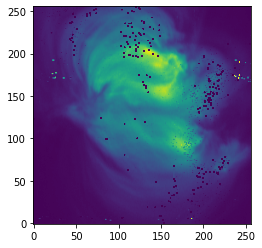

In [ ]:
fits = out.x.reshape(ny, nx, 4)
plt.imshow(fits[:,:,0]*inten_max,vmin=0, vmax=inten_max.max(), origin='lower')

## Alternative
A slower way to peform the fitting is to move the for loop to the 'outside'. Here one can make use of the automatic differentiation for calculating the jacobian and speed up the results using the standard `scipy.optimize.minimize`. 

Running the fitting this way takes around 45 minutes.

In [ ]:
# for loop on show
sg_fit = np.zeros((ny,nx,4))
for i, j in product(np.arange(nx), np.arange(ny)):
    
    x = wav_cent[j,i,:]
    y = inten_sc[j,i,:]
    y_err = errs_sc[j,i,:]
    
    guess_vals_sg = jnp.array([y.max(), 
                              x[11], 
                              0.01, 
                              y.min()], dtype='float32')
    
    res = minimize(jit_log, guess_vals_sg, method='BFGS',jac=jit_jac,
                   args=(x, y, y_err, single_gauss))
    
    sg_fit[j,i,:] = res.x

# Other tests
A similar example using `scipy.optimize.least_squares`. This has slightly better performance than `minimize` in terms of finding the best estimates for the parameters.

Also takes around 40 minutes to do the fitting.

In [ ]:

from scipy.optimize import least_squares

def residuals(p, x, y, sigma):
    # single gaussian plus constant
    # p[2] is 1/e width
    return (y-single_gauss(p,x))/sigma

jac_sg = jit(jacobian(residuals))
res_jit = jit(residuals)



In [ ]:
sg_fit = np.zeros((ny,nx,4), dtype='float32')

for i, j in product(np.arange(10), np.arange(10)):
    
    x = wav_cent[j,i,:]
    y = inten_sc[j,i,:]
    y_err = errs_sc[j,i,:]
    
    guess_vals_sg = jnp.array([y.max(), 
                              x[11], 
                              0.01, 
                              y.min()], dtype='float32')
    
    res  = least_squares(res_jit, guess_vals_sg, args=(x,y,y_err),jac=jac_sg)

    sg_fit[j,i,:] = res.x

In [ ]:
plt.imshow(sg_fit[:,:,0]*inten_max,vmin=0, origin='lower')

NameError: ignored

In [ ]:
# conversion factors

vel = ((sg_fit[:,:,1]*u.angstrom)/(284*u.angstrom)*const.c).decompose().to('km/s')
dw = np.abs(((sg_fit[:,:,2]*u.angstrom)/(284*u.angstrom)*const.c).decompose().to('km/s'))

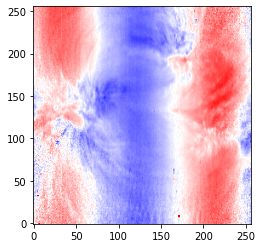

In [ ]:
plt.imshow(vel), cmap='bwr',vmax=30, vmin=-30, origin='lower')

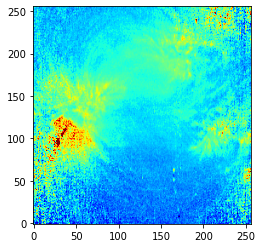

In [ ]:
plt.imshow(dw, cmap='jet',vmax=80, vmin=40, origin='lower')

In [ ]:
!pip install watermark

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.8.1
    Uninstalling importlib-metadata-4.8.1:
      Successfully uninstalled importlib-metadata-4.8.1


In [ ]:
%load_ext watermark
%watermark
%watermark --iversion

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2021-11-01T15:01:25.485112+00:00

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 5.5.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

numpy     : 1.19.5
astropy   : 4.3.1
IPython   : 5.5.0
jax       : 0.2.21
matplotlib: 3.2.2



In [ ]:
?device_put